# Introduction

Perform Sentiment Analysis on recent 100 news headlines each of FAANG(Facebook, Amazon, Apple, Netflix, Google) stocks from the site FinViz.com. The site has been chosen since it contains headlines from trusted sources and not independent bloggers in addition to being similar in length and format,

The sentiment analysis of a headline gives a polarity rating to depict the emotion behind the headline and we can get to know whether the market is feeling good or bad about a stock.
Additionally, a wordcloud is also generated to show the most used words in the 100 headlines of a stock.

# 1. Import Libraries

In [1]:
from bs4 import BeautifulSoup
import requests

import collections
import pandas as pd
from matplotlib import rcParams
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import string

from tqdm import tqdm

#### Debugging help

In [2]:
%pdb

Automatic pdb calling has been turned ON


#### Setting up figure and graph constraints

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 10

# 2. Perform Scraping

##### Tickers of FAANG companies 
- (Used GOOGL and not GOOG for Google since GOOGL has associated voting rights)

In [4]:
tickers = ['FB','AMZN','AAPL','NFLX','GOOGL']
n = 5 #the number of article headlines displayed per ticker to show correctly scraped results

#### Use requests and bs4 to scrape the website for each ticker

In [5]:
finwiz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

for ticker in tqdm(tickers):
    url = finwiz_url + ticker
    req=requests.get(url,headers={'User-agent': 'Mozilla/5.0'})
    html= BeautifulSoup(req.content, 'html.parser')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


### Cleaning the scraped html content to store and print headlines
- Finding 'tr' tag after inspection of FINVIZ website
- Only print n=5 headlines to show correct scraping

In [6]:
headline={}
try:
    for ticker in tickers:
        df = news_tables[ticker]
        table_rows = df.findAll('tr')
        headline[ticker]=[]
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        
        for i, table_row in enumerate(table_rows):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            headline[ticker].append(a_text)
            if i <= n-1:
                print(a_text,'(',td_text,')')
except KeyError:
    pass



Recent News Headlines for FB: 
3 Stocks Robinhood Investors Should Buy Hand Over Fist ( Oct-31-20 06:36AM )
Videogames Are More Popular Than Ever. Heres the Stock That Could Benefit Most ( Oct-30-20 07:47PM )
Big Tech Shares Stumble After Earnings Results ( 06:14PM )
These are the worst-performing stocks in October as Big Tech slumps ( 05:14PM )
Facebook hits pause on algorithmic recommendations for political and social issue groups ( 05:00PM )


Recent News Headlines for AMZN: 
Amazon drops French Black Friday ad campaign as lockdown starts ( Oct-31-20 05:59AM )
Amazon drops French Black Friday ad campaign as lockdown starts ( 05:42AM )
Exclusive: Amazon tells India regulator its partner Future Retail is misleading public ( 03:41AM )
Too Many Treasuries? Thats A Growing Worry, Says One Economist ( Oct-30-20 08:00PM )
Air Transport Services Group Inc (ATSG) Q3 2020 Earnings Call Transcript ( 07:01PM )


Recent News Headlines for AAPL: 
Nasdaq Hits Correction Mode, Dow Touches 200-Day

In [7]:
len(headline['GOOGL'])

100

# 3. Start Sentiment Analysis

##### Iterate through the news of each ticker and create a dataframe to store ticker,date,time and headline

In [8]:
parsed_news = []

for ticker, news_table in news_tables.items():

    for x in news_table.findAll('tr'):
        # Read the info from the tr tag into text
        head_line = x.a.get_text()
        
        # Split the text in the td tag into a list 
        # If the length of 'date_scrape' is 1, load 'time' as the only element
        # If not, load 'date' as the 1st element and 'time' as the second
        date_scrape = x.td.text.split()
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        parsed_news.append([ticker, date, time, head_line])

#### Use nltk vader module for sentiment analysis

In [9]:
analyzer = SentimentIntensityAnalyzer()

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
scores = news['Headline'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')

In [10]:
news.head()

,Ticker,Date,Time,Headline,compound,neg,neu,pos
0,FB,Oct-31-20,06:36AM,3 Stocks Robinhood Investors Should Buy Hand O...,0.4939,0.0,0.686,0.314
1,FB,Oct-30-20,07:47PM,Videogames Are More Popular Than Ever. Heres t...,0.7264,0.0,0.644,0.356
2,FB,Oct-30-20,06:14PM,Big Tech Shares Stumble After Earnings Results,0.2960,0.0,0.732,0.268
3,FB,Oct-30-20,05:14PM,These are the worst-performing stocks in Octob...,0.0000,0.0,1.000,0.000
4,FB,Oct-30-20,05:00PM,Facebook hits pause on algorithmic recommendat...,0.0000,0.0,1.000,0.000


## 4. View data utlising pandas dataframe

In [11]:
# View Data 
news['Date'] = pd.to_datetime(news.Date).dt.date

unique_ticker = news['Ticker'].unique().tolist()
news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}

values = []
for ticker in tickers: 
    dataframe = news_dict[ticker]
    dataframe = dataframe.set_index('Ticker')
    dataframe = dataframe.drop(columns = ['Headline'])
    print ('\n')
    print (dataframe.head())
    
    mean = round(dataframe['compound'].mean(), 2)
    values.append(mean)
    
df = pd.DataFrame(list(zip(tickers, values)), columns =['Ticker', 'Mean Sentiment']) 
df = df.set_index('Ticker')
df = df.sort_values('Mean Sentiment', ascending=False)
print ('\n')
print (df)



              Date     Time  compound  neg    neu    pos
Ticker                                                  
FB      2020-10-31  06:36AM    0.4939  0.0  0.686  0.314
FB      2020-10-30  07:47PM    0.7264  0.0  0.644  0.356
FB      2020-10-30  06:14PM    0.2960  0.0  0.732  0.268
FB      2020-10-30  05:14PM    0.0000  0.0  1.000  0.000
FB      2020-10-30  05:00PM    0.0000  0.0  1.000  0.000


              Date     Time  compound    neg    neu    pos
Ticker                                                    
AMZN    2020-10-31  05:59AM    0.1779  0.000  0.841  0.159
AMZN    2020-10-31  05:42AM    0.1779  0.000  0.841  0.159
AMZN    2020-10-31  03:41AM   -0.1280  0.181  0.604  0.215
AMZN    2020-10-30  08:00PM   -0.0772  0.232  0.480  0.288
AMZN    2020-10-30  07:01PM    0.0000  0.000  1.000  0.000


              Date     Time  compound    neg    neu    pos
Ticker                                                    
AAPL    2020-10-30  06:58PM    0.0000  0.000  1.000  0.000
AAPL 

## Use Sentiment Analyser again for graphical representations

In [12]:
columns = ['ticker', 'date', 'time', 'headline']
scored_news = pd.DataFrame(parsed_news, columns=columns)
scores = [analyzer.polarity_scores(headline) for headline in scored_news.headline.values]

scores_df = pd.DataFrame(scores)
scored_news = pd.concat([scored_news, scores_df], axis=1)
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

### Cleaning the headlines to avoid repetition

#### Drop duplicates based on ticker and headline

In [13]:
num_news_before = scored_news['headline'].count()
scored_news_clean = scored_news.drop_duplicates(subset=['ticker', 'headline'])
num_news_after = scored_news_clean['headline'].count()
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 500 headlines, now we have 487'

## Plot sentiments
- Group by date and ticker columns from scored_news and calculate the mean
- Only get the compound sentiments
- Note: Different stocks may have recent 100 headlines start/finish at different times

<AxesSubplot:title={'center':'Compound Sentiments of Every Stock'}, xlabel='date'>

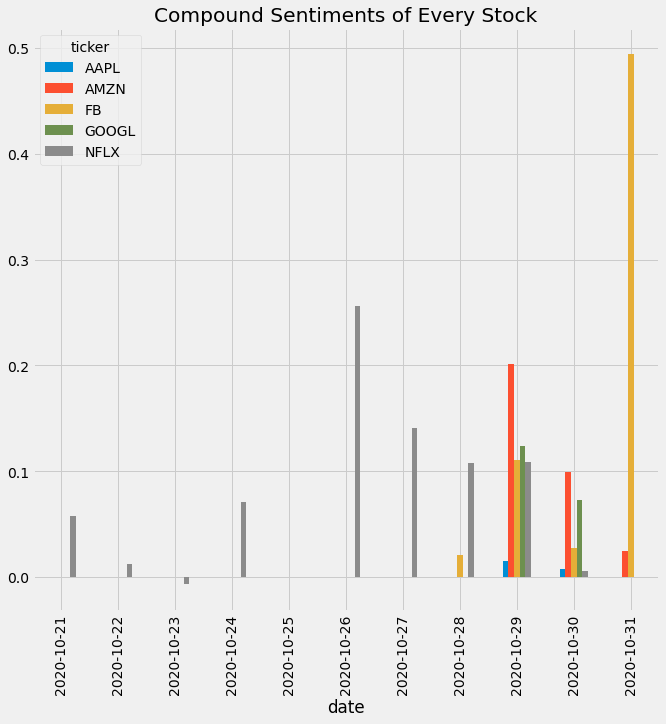

In [14]:
plt.style.use("fivethirtyeight")

compound = scored_news_clean.groupby(['date', 'ticker']).mean()
compound = compound.unstack(level=1)
compound = compound.xs('compound', axis=1)
compound.plot.bar(title='Compound Sentiments of Every Stock')

## Single Stock Sentiment
- Get the sentiment of a stock on a particular day

In [15]:
single_day = scored_news_clean.set_index(['ticker', 'date'])
#Choose facebook as the stock
stock = 'FB'
single_day = single_day.loc[stock]
# Select the day
day = '2020-10-30'
single_day = single_day.loc[day]

single_day['time'] = pd.to_datetime(single_day['time'])
single_day['time'] = single_day.time.dt.time 
single_day = single_day.set_index('time')
single_day = single_day.sort_index()

- Drop the columns that aren't useful for the plot
- Change the column names to 'negative', 'positive', and 'neutral'

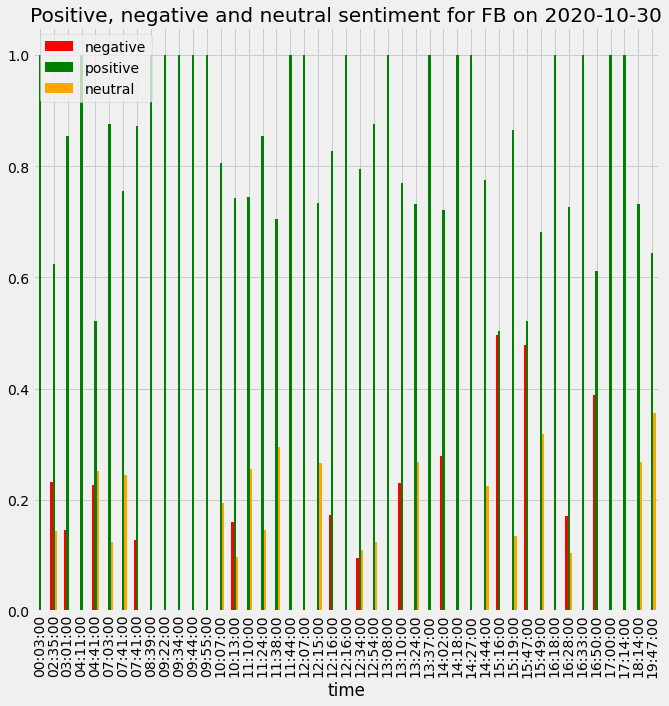

In [16]:
try:
    TITLE = f"Positive, negative and neutral sentiment for {stock} on {day}"
    COLORS = ["red", "green", "orange"]
    plot_day = single_day.drop(['headline', 'compound'], axis=1)
    plot_day.columns = ['negative', 'positive', 'neutral']
    plot_day.plot.bar(title=TITLE,color=COLORS)
except:
    print('No data for the stock on this day')
    print('Please select a date from the graph generated above')

# 4. Show WORDCLOUD of Sentiments for a particular stock

In [17]:
stock_ticker = 'AAPL'

In [18]:
text = " ".join(des for des in headline[stock_ticker])
print (f"There are {len(text)} words for {stock_ticker} in the combination of all review.")

There are 6796 words for AAPL in the combination of all review.


##### Clean the text to get one format 

In [19]:
text= string.capwords(text.replace(',','').lower())
text=text.replace('.',' ')

##### Generate a word cloud image and display it using matplotlib

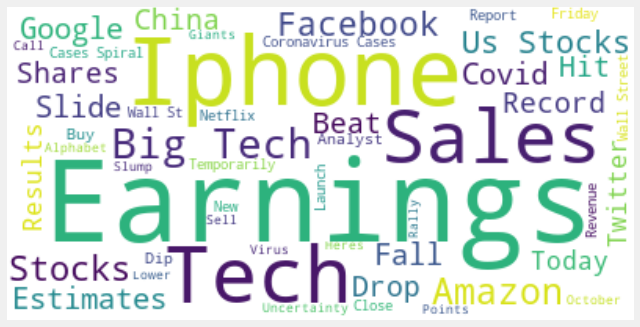

In [20]:
stopwords = set(STOPWORDS)
# certain stopwords added related to apple and stock market
stopwords.update(["aapl","yes", "apple","stock","market","dow","jones","NASDAQ","S&P","500","Q4"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Using stopwords to find top words in the headline of a stock

In [21]:
filtered_words = [word for word in text.split() if word.lower() not in stopwords]
counted_words = collections.Counter(filtered_words)

words = []
counts = []

for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)

<BarContainer object of 10 artists>

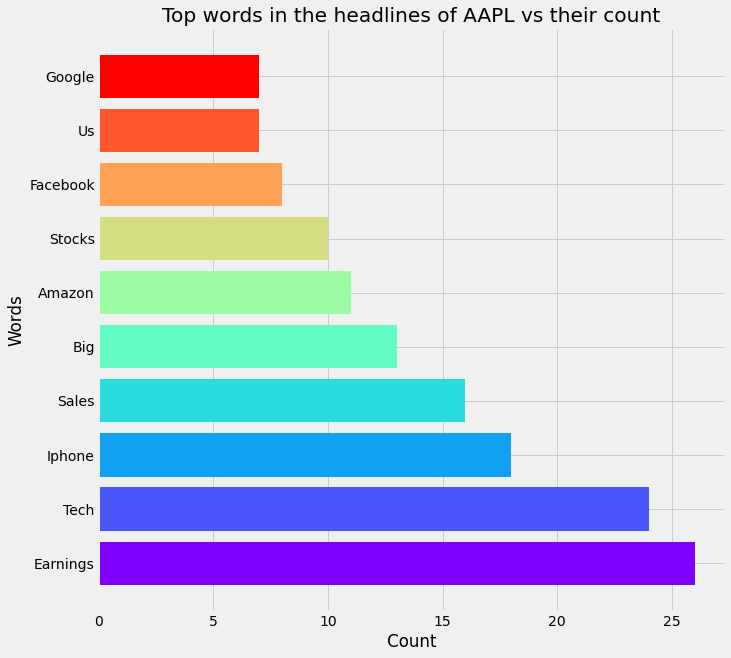

In [22]:

colors = cm.rainbow(np.linspace(0, 1, 10))

plt.title(f'Top words in the headlines of {stock_ticker} vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)